In [1]:
%matplotlib inline
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
stocks = []
with open('data/stocknames.txt') as f:
    for line in f:
        stocks.append(line.rstrip())

In [3]:
cormat_1h = np.load('data/cormat_1h.npy')
cormat_1m = np.load('data/cormat_1m.npy')

In [4]:
hour_eval, hour_evec = np.linalg.eig(cormat_1h)
min_eval, min_evec = np.linalg.eig(cormat_1m)

In [5]:
def MPlaw(x,Q):
    lambdamin = 1 + 1/Q - 2*np.sqrt(1/Q)
    lambdamax = 1 + 1/Q + 2*np.sqrt(1/Q)
    if x <= lambdamax and x >= lambdamin:
        res = Q/(2*np.pi) * np.sqrt((lambdamax - x) * (x - lambdamin))/x
        return res
    else:
        return 0

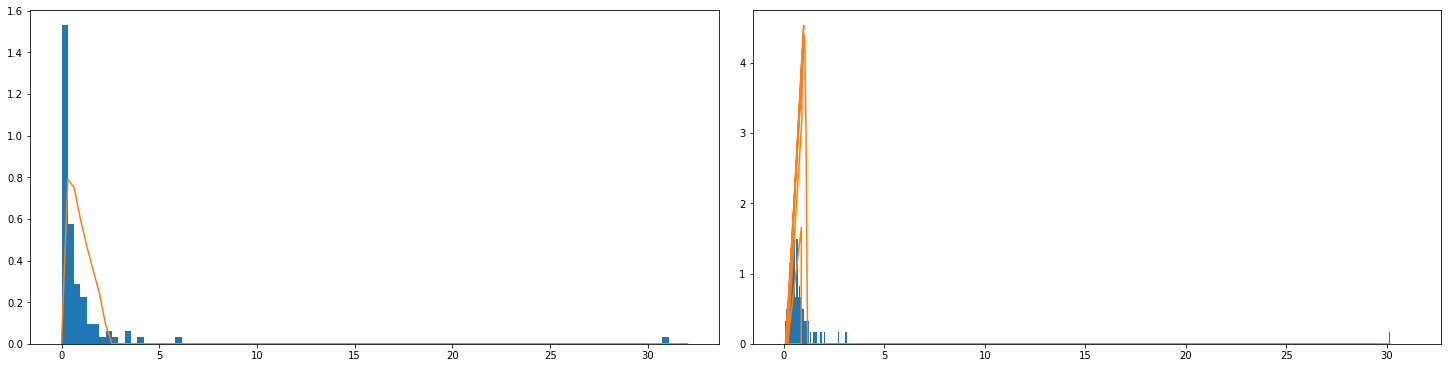

In [6]:
fig,axs = plt.subplots(1,2, constrained_layout=True, figsize=(20,5))

xvals_h = np.linspace(0,max(hour_eval)+1,100)
Qh = 3.6289
xvals_m = np.linspace(0,max(min_eval)+1,500)
Qm = 200.8969

MPvals_h = [MPlaw(x, Qh) for x in xvals_h]
MPvals_m = [MPlaw(x, Qm) for x in xvals_m]

axs[0].hist(hour_eval, density=True, bins=xvals_h)
axs[0].plot(xvals_h, MPvals_h)
axs[1].hist(min_eval, density=True, bins=xvals_m)
axs[1].plot(min_eval, MPvals_m)

plt.show()

In [7]:
lambdamax_h = 1 + 1/Qh + 2*np.sqrt(1/Qh)
lambdamax_m = 1 + 1/Qm + 2*np.sqrt(1/Qm)

hour_eval_f = hour_eval.copy()
min_eval_f = min_eval.copy()

In [8]:
hour_eval_f[hour_eval_f < lambdamax_h] = 0.5
min_eval_f[min_eval_f < lambdamax_m] = 0.5

In [9]:
hour_eval_f = hour_eval_f * len(hour_eval_f)/sum(hour_eval_f)
min_eval_f = min_eval_f * len(min_eval_f)/sum(min_eval_f)

In [10]:
#np.matmul表示将矩阵相乘
denoised_h = np.matmul(np.matmul(hour_evec, np.diag(hour_eval_f)), np.linalg.inv(hour_evec))
denoised_m = np.matmul(np.matmul(min_evec, np.diag(min_eval_f)), np.linalg.inv(min_evec))

# rescale 

In [11]:
denoised_h_D = np.diag(denoised_h)
denoised_m_D = np.diag(denoised_m)

Dh = np.diag(np.sqrt(1/denoised_h_D))
Dm = np.diag(np.sqrt(1/denoised_m_D))

In [13]:
denoised_h_norm = np.matmul(np.matmul(Dh, denoised_h), Dh)

np.fill_diagonal(denoised_h_norm, 1)
denoised_m_norm = np.matmul(np.matmul(Dm, denoised_m), Dm)
np.fill_diagonal(denoised_m_norm, 1)

In [14]:
def upper_tri(A):
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:,None] < r
    return A[mask]

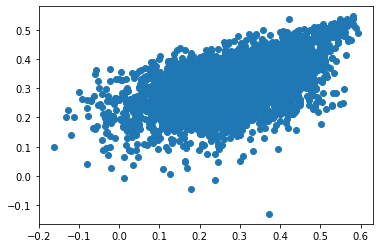

In [15]:
plt.scatter(upper_tri(denoised_h_norm), upper_tri(denoised_m_norm))

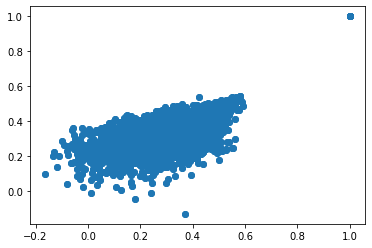

In [16]:
plt.scatter(denoised_h_norm, denoised_m_norm)

In [17]:
hour_dist = np.sqrt(2 * (1 - denoised_h_norm))
min_dist = np.sqrt(2 * (1 - denoised_m_norm))

h_net = nx.from_numpy_array(hour_dist)
m_net = nx.from_numpy_array(min_dist)

In [18]:
hour_MST = nx.minimum_spanning_tree(h_net)
min_MST = nx.minimum_spanning_tree(m_net)

In [19]:
stocks_d = {i:v for i,v in enumerate(stocks)}

In [20]:
nx.set_node_attributes(hour_MST, stocks_d, 'stock_name')
nx.set_node_attributes(min_MST, stocks_d, 'stock_name')

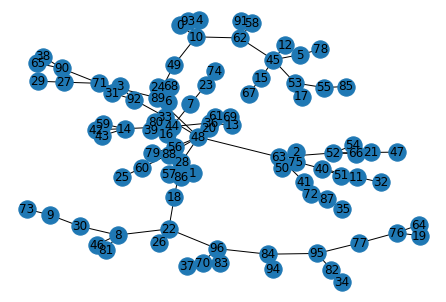

In [21]:
ax = nx.draw(hour_MST, with_labels=True)


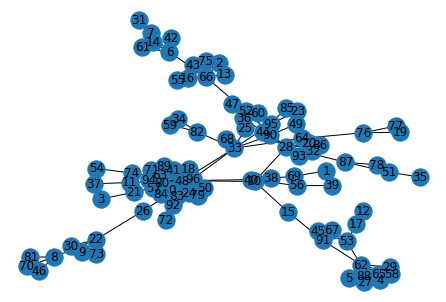

In [22]:
ax = nx.draw(min_MST, with_labels=True)

In [23]:
hour_deg = [d for n,d in nx.degree(hour_MST)]
min_deg = [d for n,d in nx.degree(min_MST)]

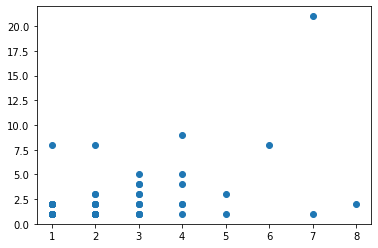

In [24]:
plt.scatter(hour_deg, min_deg)

In [25]:
stocks[int(np.where(np.abs(hour_evec[:,0]) == np.max(np.abs(hour_evec[:,0])))[0])]

'HON'

In [26]:
stocks[int(np.where(np.abs(min_evec[:,0]) == np.max(np.abs(min_evec[:,0])))[0])]

'HON'

In [27]:
hd = [d for n,d in nx.degree(hour_MST)]
md = [d for n,d in nx.degree(min_MST)]

In [28]:
print([nx.get_node_attributes(hour_MST, 'stock_name')[n] for n in np.argsort(hd)[-5:]])
print([nx.get_node_attributes(min_MST, 'stock_name')[n] for n in np.argsort(md)[-5:]])

['AXP', 'DIS', 'MMM', 'HON', 'GOOG']
['DIS', 'EMR', 'MRK', 'MET', 'HON']


In [29]:
print([nx.get_node_attributes(hour_MST, 'stock_name')[n] for n in np.argsort(hd)])
print([nx.get_node_attributes(min_MST, 'stock_name')[n] for n in np.argsort(md)])

['AAPL', 'FCX', 'FDX', 'FOXA', 'SPG', 'GM', 'HAL', 'HD', 'IBM', 'INTC', 'KO', 'LOW', 'MA', 'MCD', 'MDT', 'F', 'TWX', 'MO', 'MON', 'MRK', 'MS', 'MSFT', 'NKE', 'ORCL', 'OXY', 'PEP', 'PFE', 'QCOM', 'RTN', 'SBUX', 'SLB', 'TGT', 'EXC', 'GILD', 'EMC', 'BMY', 'BAX', 'BAC', 'V', 'USB', 'VZ', 'CSCO', 'CL', 'CVS', 'AIG', 'ACN', 'ABT', 'DOW', 'ABBV', 'EBAY', 'CVX', 'C', 'ALL', 'AMZN', 'PM', 'NOV', 'APC', 'BA', 'SO', 'BK', 'CAT', 'EMR', 'CMCSA', 'LMT', 'LLY', 'COF', 'DVN', 'TXN', 'COST', 'HPQ', 'MDLZ', 'UNH', 'DD', 'FB', 'UPS', 'GD', 'GE', 'WMT', 'UNP', 'AMGN', 'NSC', 'JPM', 'UTX', 'PG', 'T', 'XOM', 'MET', 'JNJ', 'COP', 'BIIB', 'APA', 'GS', 'AXP', 'DIS', 'MMM', 'HON', 'GOOG']
['AAPL', 'F', 'RTN', 'FCX', 'FDX', 'FOXA', 'QCOM', 'GE', 'GILD', 'GM', 'PM', 'GS', 'HAL', 'HD', 'PFE', 'HPQ', 'IBM', 'OXY', 'ORCL', 'KO', 'LLY', 'NSC', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT', 'NOV', 'MMM', 'MON', 'EXC', 'MSFT', 'SBUX', 'EBAY', 'ABBV', 'ABT', 'ACN', 'AIG', 'ALL', 'VZ', 'V', 'APC', 'BAC', 'BAX', 'EMC', 'UNP', 'BMY',

In [30]:
np.argsort(hd)

array([ 0, 37, 38, 39, 83, 43, 46, 47, 50, 51, 54, 57, 58, 59, 61, 35, 86,
       64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 78, 79, 80, 81, 85, 34, 42,
       32, 16, 13, 12, 93, 91, 94, 24, 19, 25,  4,  3,  2, 29,  1, 31, 26,
       17,  5,  7, 77, 70,  9, 11, 82, 15, 18, 33, 20, 56, 55, 21, 30, 87,
       23, 49, 60, 88, 27, 36, 90, 40, 41, 95, 89,  6, 71, 53, 92, 76, 84,
       96, 62, 52, 22, 14,  8, 45, 10, 28, 63, 48, 44])

In [31]:
np.argsort(md)

array([ 0, 35, 79, 37, 38, 39, 78, 41, 42, 43, 77, 45, 46, 47, 75, 49, 50,
       73, 72, 54, 55, 71, 57, 58, 59, 60, 61, 70, 63, 65, 34, 68, 80, 31,
        1,  2,  3,  4,  5, 94, 93,  9, 12, 13, 32, 89, 16, 14, 18, 30, 29,
       81, 27, 83, 84, 24, 88, 67, 85, 86, 20, 19, 23, 91, 90, 74, 69, 92,
       96, 64,  7, 56, 52, 51, 11, 15, 44, 17, 36, 21, 25, 26, 10, 87, 82,
       76, 95, 40, 53,  8, 22,  6, 28, 33, 66, 62, 48])

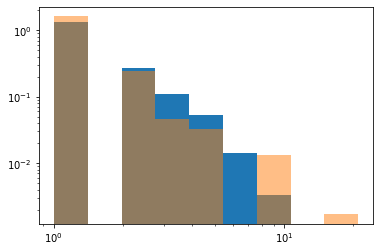

In [32]:
plt.hist(hd, density=True, bins=np.logspace(np.log10(min(hd + md)), np.log10(max(hd+md)), 10))
plt.hist(md, density=True, bins=np.logspace(np.log10(min(hd + md)), np.log10(max(hd+md)), 10), alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.show()